In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from math import pi
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import os
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [6]:
os.environ["OMP_NUM_THREADS"]="15"

# Reading and organizing the Data


In [43]:
url = "https://drive.google.com/file/d/1Q32l5eGrprLgqZ4mRLStNn3VFXeO4A0M/view?usp=drive_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

original_songs_5000_df = pd.read_csv(path)
original_songs_5000_df.columns = original_songs_5000_df.columns.str.strip()

In [44]:
original_songs_5000_df.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'id',
       'html'],
      dtype='object')

In [45]:
original_songs_5000_df.sample(5)

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html
2256,No Diggity ...,Blackstreet,0.865,0.650,1,-4.617,0,0.2070,0.324,0.000000,0.1330,0.7150,88.663,,305707,4,4l2ecMeHvDg2Y9OOkqfucN,https://open.spotify.com/track/4l2ecMeHvDg2Y9O...
4652,Mixtape : OH ...,Stray Kids,0.745,0.684,11,-4.398,0,0.0698,0.201,0.000000,0.1490,0.6290,87.980,,212480,4,3lYHmpjkm95UbQz76S47xZ,https://open.spotify.com/track/3lYHmpjkm95UbQz...
1840,Air on a G String ...,Johann Sebastian Bach,0.109,0.314,2,-11.270,1,0.0390,0.982,0.895000,0.1080,0.0557,172.773,,289640,3,0mD1a7haZKdX9I0oPywrMb,https://open.spotify.com/track/0mD1a7haZKdX9I0...
461,A Minha Menina ...,Os Mutantes,0.606,0.492,7,-8.247,1,0.0419,0.720,0.000000,0.1250,0.6160,108.289,,222617,4,1XGwjdHXHNu3842f75eg3T,https://open.spotify.com/track/1XGwjdHXHNu3842...
1522,All My Life ...,K-Ci & JoJo,0.629,0.511,1,-8.651,1,0.0326,0.114,0.000004,0.0588,0.1810,128.038,,331240,4,5GorFaKkP2mLREQvhSblIg,https://open.spotify.com/track/5GorFaKkP2mLREQ...


In [46]:
songs_5000_df = original_songs_5000_df.copy()

In [47]:
songs_5000_df.set_index(['name', 'artist'], inplace=True)
songs_5000_df.drop(['type', 'id', 'html'], axis=1, inplace=True)

# Checking Variance and Correlations on the Columns

In [48]:
songs_5000_df[["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "mode", "duration_ms", "key", "time_signature"]].var()

danceability        4.754189e-02
energy              8.313705e-02
loudness            3.962514e+01
speechiness         5.068469e-03
acousticness        1.267251e-01
instrumentalness    1.374083e-01
liveness            2.232329e-02
valence             7.713127e-02
tempo               8.161571e+02
mode                2.286613e-01
duration_ms         1.839632e+10
key                 1.275603e+01
time_signature      1.766725e-01
dtype: float64

In [55]:
songs_5000_df[["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "mode", "duration_ms", "key", "time_signature"]].corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,mode,duration_ms,key,time_signature
danceability,1.000000,0.040491,0.358328,0.036121,-0.111151,-0.573800,-0.032534,0.680097,-0.009585,-0.088908,-0.216842,0.002152,0.215498
energy,0.040491,1.000000,0.786860,0.303940,-0.850469,-0.169923,0.170642,0.159101,0.211617,-0.008461,-0.150798,0.029702,0.162435
loudness,0.358328,0.786860,1.000000,0.233609,-0.697709,-0.471786,0.134788,0.335754,0.213228,-0.030855,-0.208118,0.027082,0.215875
speechiness,0.036121,0.303940,0.233609,1.000000,-0.265754,-0.064754,0.081963,-0.011395,0.064255,-0.041282,-0.040975,0.027547,0.060871
acousticness,-0.111151,-0.850469,-0.697709,-0.265754,1.000000,0.194941,-0.103144,-0.130646,-0.187994,0.028854,0.117598,-0.024794,-0.163980
instrumentalness,-0.573800,-0.169923,-0.471786,-0.064754,0.194941,1.000000,-0.051664,-0.500584,-0.071945,-0.003017,0.192449,-0.016775,-0.160122
liveness,-0.032534,0.170642,0.134788,0.081963,-0.103144,-0.051664,1.000000,0.007272,0.036370,-0.009712,-0.006398,0.025193,0.025039
valence,0.680097,0.159101,0.335754,-0.011395,-0.130646,-0.500584,0.007272,1.000000,0.098783,0.005966,-0.233910,-0.018109,0.189048
tempo,-0.009585,0.211617,0.213228,0.064255,-0.187994,-0.071945,0.036370,0.098783,1.000000,0.004739,-0.072870,-0.002370,0.024075
mode,-0.088908,-0.008461,-0.030855,-0.041282,0.028854,-0.003017,-0.009712,0.005966,0.004739,1.000000,-0.008603,-0.155697,-0.013039


# Dropping unwanted columns

In [56]:
songs_5000_df.drop(["key", "mode", "time_signature", "duration_ms", "tempo", "loudness", "speechiness"], axis=1, inplace=True)
songs_5000_df

,,danceability,energy,acousticness,instrumentalness,liveness,valence
name,artist,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.6580,0.25900,0.694,0.000059,0.9750,0.3060
Saudade De Bahia,Antônio Carlos Jobim,0.7420,0.39900,0.217,0.000002,0.1070,0.6930
"Canta Canta, Minha Gente",Martinho Da Vila,0.8510,0.73000,0.453,0.000063,0.1240,0.9050
Mulher Eu Sei,Chico César,0.7050,0.05020,0.879,0.000041,0.3860,0.5240
Rosa Morena,Kurt Elling,0.6510,0.11900,0.916,0.000343,0.1040,0.4020
...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,0.917,0.715000,0.0832,0.0655
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.1880,0.10100,0.855,0.426000,0.0694,0.0355
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.0596,0.00093,0.951,0.969000,0.0772,0.0344


Reasons to drop the features:

key: doesn't matter because people don't have that much interest on listening a song with a specific key

mode: there are only 2 values (0 and 1) and almost 70% of the data got the value of 1 so this will lead to a biased prediction and this feature is also represented in variance with a better range

time_signature: more than 80% of the songs have 4/4 and it is not that important to listeners 

duration_ms: is as well not on the focus of listeners

tempo: is found more detailed in energy and valence

loudness: people can turn up the volume themselves , goes also along with energy and the correlation between the energy and loudness is high

speechiness: the variance is too small compared to the others features

# Scaling

No need to scale

# Choosing the right Clusters

## Elbow method 

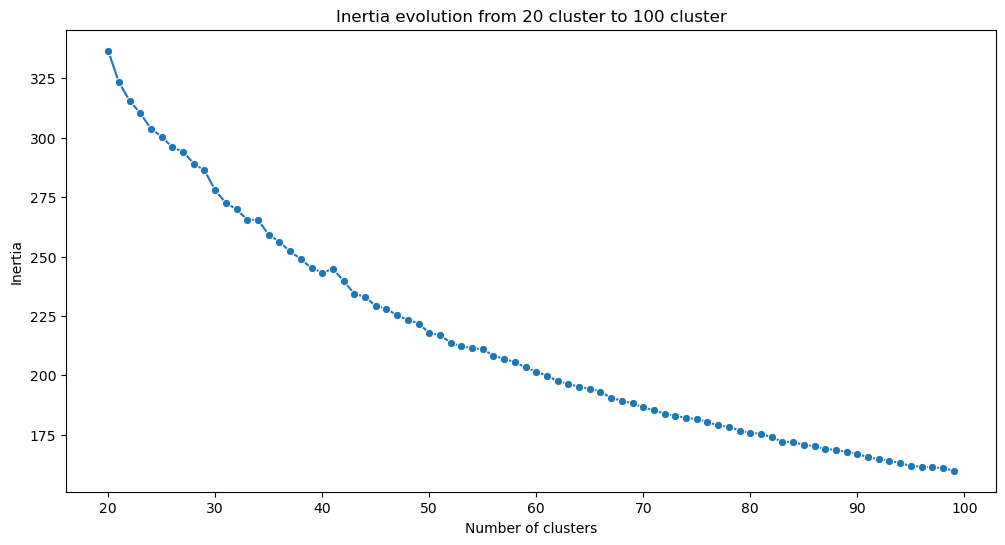

In [57]:
max_k = 100
inertia = []

for k in range(20, max_k):
    inertia.append(KMeans(n_clusters=k, n_init="auto", random_state=42).fit(songs_5000_df).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 20 cluster to {max_k} cluster')
sns.lineplot(x=range(20, max_k), y=inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Silhouette Score

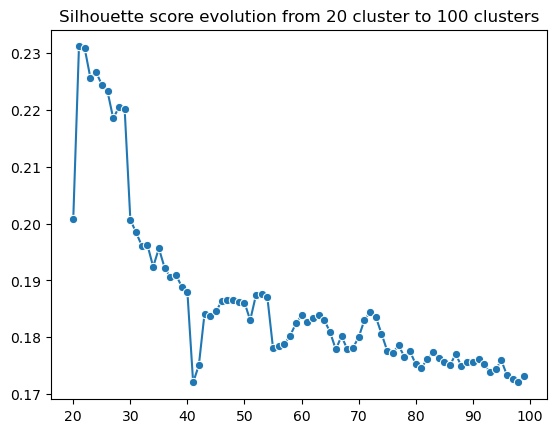

In [59]:
max_k = 100
sil_score = []

for k in range(20, max_k):
    labels = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(songs_5000_df).labels_
    sil_score.append(silhouette_score(songs_5000_df, labels))

plt.title(f'Silhouette score evolution from 20 cluster to {max_k} clusters')
sns.lineplot(x=range(20, max_k), y=sil_score, marker='o')
plt.show()

The clusters choosen was 22

# Calculating the Centroids

In [60]:
kmeans = KMeans(n_clusters=22, n_init="auto", random_state=42)
kmeans.fit(songs_5000_df)
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = ["danceability", "energy", "acousticness", "instrumentalness", "liveness", "valence"]
centroids

,danceability,energy,acousticness,instrumentalness,liveness,valence
0,0.623440,0.589770,0.684603,0.023052,0.170460,0.820550
1,0.278001,0.944271,0.004101,0.063018,0.180085,0.178593
2,0.286496,0.108250,0.944160,0.875891,0.126019,0.119205
3,0.729103,0.666806,0.102716,0.009310,0.136428,0.527370
4,0.282204,0.901000,0.010111,0.470768,0.202239,0.204589
5,0.546887,0.509585,0.519589,0.019727,0.153517,0.405686
6,0.762306,0.541062,0.151776,0.013480,0.107046,0.818419
7,0.345354,0.165928,0.905559,0.056266,0.175925,0.189453
8,0.530750,0.843473,0.069300,0.017259,0.656670,0.387744
9,0.225555,0.920561,0.010108,0.856682,0.200132,0.130395


In [63]:
eucl_centroids  = pd.DataFrame(pairwise_distances(kmeans.cluster_centers_),
                index=centroids.index,
                columns=centroids.index)
eucl_centroids

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.000000,1.059189,1.278264,0.665578,1.117638,0.460359,0.556488,0.839769,0.935580,1.376522,...,1.239541,0.596170,0.929014,0.939823,0.828282,0.667760,0.846888,0.443246,1.131257,0.743180
1,1.059189,0.000000,1.499975,0.645477,0.411526,0.762319,0.914386,1.192963,0.592675,0.797481,...,0.804777,1.063714,0.960098,1.369549,0.471415,0.785993,0.385994,1.146124,0.828565,0.460112
2,1.278264,1.499975,0.000000,1.460679,1.295431,1.106787,1.508180,0.829151,1.567337,1.241774,...,1.248020,1.299167,1.335124,0.476267,1.319399,1.639368,1.487267,1.003267,1.199608,1.515512
3,0.665578,0.645477,1.460679,0.000000,0.764594,0.496902,0.323899,1.077335,0.601567,1.098279,...,0.992199,0.815164,0.763889,1.185685,0.363712,0.326096,0.306244,0.820617,0.821873,0.323509
4,1.117638,0.411526,1.295431,0.764594,0.000000,0.853864,0.987464,1.232428,0.717155,0.397530,...,0.408944,1.119687,0.719206,1.161295,0.629769,0.886073,0.575051,1.189895,0.499422,0.609183
5,0.460359,0.762319,1.106787,0.496902,0.853864,0.000000,0.596011,0.596894,0.753653,1.144631,...,1.075827,0.607392,0.940287,0.894181,0.452538,0.703911,0.585416,0.393223,0.945950,0.609203
6,0.556488,0.914386,1.508180,0.323899,0.987464,0.596011,0.000000,1.133550,0.799659,1.282662,...,1.125661,0.822798,0.763545,1.177658,0.628092,0.297762,0.617666,0.790024,0.977839,0.497130
7,0.839769,1.192963,0.829151,1.077335,1.232428,0.596894,1.133550,0.000000,1.210258,1.424919,...,1.408035,0.847262,1.380933,0.838503,0.919444,1.288785,1.129420,0.447276,1.319147,1.168127
8,0.935580,0.592675,1.567337,0.601567,0.717155,0.753653,0.799659,1.210258,0.000000,1.040133,...,0.981362,0.687105,0.915234,1.343972,0.601224,0.716711,0.479210,1.076731,0.891486,0.531212
9,1.376522,0.797481,1.241774,1.098279,0.397530,1.144631,1.282662,1.424919,1.040133,0.000000,...,0.255625,1.371109,0.787823,1.154509,0.977406,1.199940,0.943748,1.418495,0.479680,0.971234


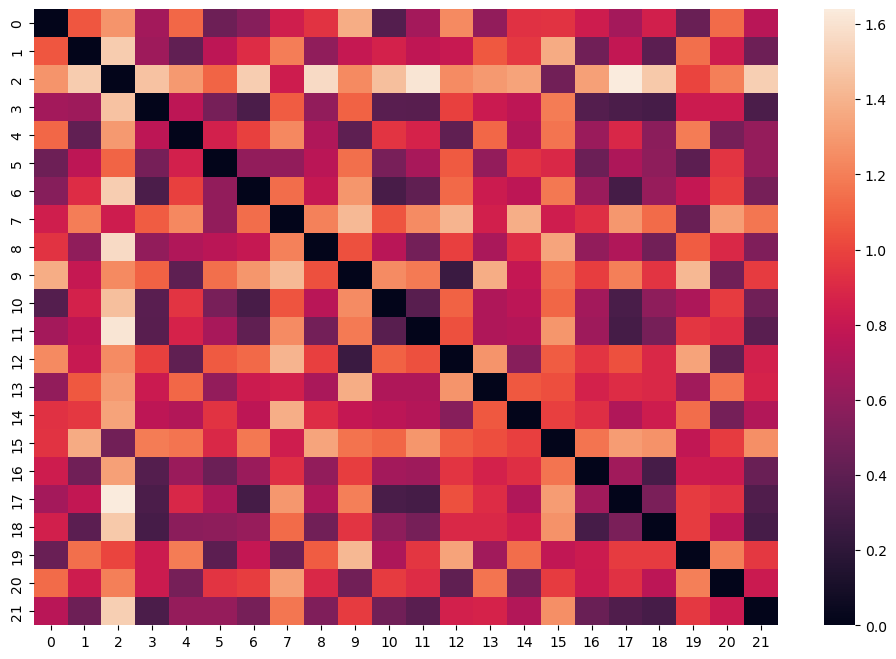

In [64]:
plt.subplots(figsize=(12, 8))
sns.heatmap(eucl_centroids);

# Giving cluster numbers to our original data 

In [68]:
original_songs_5000_df["clusters"] = kmeans.labels_
original_songs_5000_df.sample(30)

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,clusters
3494,Ritual of Infinity ...,Morpheus Descends,0.1570,0.8530,8,-11.703,1,0.0942,0.043300,0.955000,0.1780,0.3000,96.274,,240640,4,1zKSiUgqU0NAIwUkbTReAh,https://open.spotify.com/track/1zKSiUgqU0NAIwU...,12
328,Nothing To Be Done ...,The Pastels,0.6590,0.6490,0,-15.884,1,0.0667,0.469000,0.446000,0.1280,0.9660,92.458,,122160,4,2JXzKmttRH5Hj1Q587ParV,https://open.spotify.com/track/2JXzKmttRH5Hj1Q...,10
2690,Alive ...,Empire of the Sun,0.6490,0.7470,5,-3.054,1,0.0489,0.005840,0.017100,0.6980,0.0609,127.961,,227240,4,5MrQhCbUZnAa2EIGQt5DHu,https://open.spotify.com/track/5MrQhCbUZnAa2EI...,8
2113,Perfect ...,Henry Smith,0.3720,0.0709,8,-19.146,1,0.0467,0.993000,0.949000,0.1040,0.1200,164.653,,272000,3,77OfUElb1qTM1txv6oH3O1,https://open.spotify.com/track/77OfUElb1qTM1tx...,2
1924,Søndag am ...,Søndag Søndag,0.2570,0.0440,6,-26.193,1,0.0379,0.927000,0.766000,0.2210,0.1510,90.574,,245707,3,61YWCLO6iBOvwmwlzaKxnD,https://open.spotify.com/track/61YWCLO6iBOvwmw...,2
852,Be-Bop-A-Lula ...,Gene Vincent & His Blue Caps,0.6070,0.5610,9,-10.099,1,0.0425,0.421000,0.000000,0.2980,0.8410,127.638,,157207,3,0TMrV95mP7sDlvbE4iVfKP,https://open.spotify.com/track/0TMrV95mP7sDlvb...,10
3723,Rage Within ...,Resurrection,0.2980,0.9780,9,-5.651,1,0.1320,0.000022,0.181000,0.3370,0.1400,147.180,,241587,4,2WYUv7xwTrZOMtv0OwKf4c,https://open.spotify.com/track/2WYUv7xwTrZOMtv...,1
608,High Hopes ...,Panic! At The Disco,0.5790,0.9040,5,-2.729,1,0.0618,0.193000,0.000000,0.0640,0.6810,82.014,,190947,4,1rqqCSm0Qe4I9rUvWncaom,https://open.spotify.com/track/1rqqCSm0Qe4I9rU...,21
2989,You Can't Change Me ...,Don Diablo,0.5480,0.9290,3,-2.739,0,0.0543,0.288000,0.317000,0.0376,0.5380,123.809,,187186,4,5QewRG7VkZtBkAxWT5prZq,https://open.spotify.com/track/5QewRG7VkZtBkAx...,21
3220,Bien Loco ...,Nova y Jory,0.5150,0.8120,7,-5.060,0,0.3610,0.411000,0.000000,0.1010,0.7790,169.981,,218044,4,4ObjArCiona7v0xbZ83rUZ,https://open.spotify.com/track/4ObjArCiona7v0x...,10


# How many songs are in each cluster

In [69]:
original_songs_5000_df.groupby("clusters").size().reset_index(name='count')

,clusters,count
0,0,209
1,1,340
2,2,495
3,3,397
4,4,190
5,5,248
6,6,258
7,7,204
8,8,112
9,9,374


# Importing playlists to Spotify

In [ ]:
# !pip install spotipy

Authentication with Spotify

In [ ]:
scope = 'playlist-modify-public' 
username = 'username'
redirectUri = 'redirectUri'
client_id = 'client_id'
client_secret = 'client_secret'

token = SpotifyOAuth(scope=scope,
                     username=username,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=redirectUri,
                     open_browser=False # this line is need in Colab, but not on local machine
                     )
spotifyObject = spotipy.Spotify(auth_manager = token)

Using a loop to add the songs using the id

In [ ]:
playlist_collection = {}
for i in range(1):
    playlist_name = f'my_playlist_cluster_{i}'
    playlist_description= 'this is a test list'
    playlist_id = spotifyObject.user_playlist_create(user=username,
                                                     name=playlist_name,
                                                     public=True,
                                                     description=playlist_description)['id']
    id_list = list(original_songs_5000_df.loc[original_songs_5000_df["cluster"] == i]
                                .sample(5)
                                .id)
    uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
    spotifyObject.user_playlist_add_tracks(user=username,playlist_id=playlist_id,tracks=uris)
    playlist_collection[playlist_name] = playlist_id